라이브러리

In [2]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense, Attention, Input
from keras.models import Model
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
tank = 1
model_name = 'rereredoRegressor_tank1dofood'

In [3]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

데이터셋 설정

In [4]:
#자포니카 훈련 데이터
japonica_training_food_supply_tb = pd.read_csv("eeldata/data/Training/Origin/Management/Japonica/food_supply_tb.csv")
japonica_training_sensor_val_tb = pd.read_csv("eeldata/data/Training/Origin/Sensor/Japonica/sensor_val_tb.csv")

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("eeldata/data/Validation/Origin/Management/Japonica/food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("eeldata/data/Validation/Origin/Sensor/Japonica/sensor_val_tb.csv")


In [5]:
# 자포니카 사료 공급 데이터 정제
# null제거
japonica_training_food_supply_tb = japonica_training_food_supply_tb[japonica_training_food_supply_tb['feed_quantity'].notnull()]
japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]

# 시계열 데이터 변환
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

In [6]:
# 자포니카 센서 데이터 정제

# 한 개 탱크
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[japonica_training_sensor_val_tb['tank_id']==tank]
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[japonica_validation_sensor_val_tb['tank_id']==tank]

#시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_training_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 시계열 데이터의 개수 확인
training_counts = japonica_training_sensor_val_tb.groupby(japonica_training_sensor_val_tb['mea_dt'].dt.date).size()
validation_counts = japonica_validation_sensor_val_tb.groupby(japonica_validation_sensor_val_tb['mea_dt'].dt.date).size()

# 개수가 1440이 아닌 시계열 삭제
to_delete = training_counts[training_counts != 1440].index
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[~japonica_training_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]
to_delete = validation_counts[validation_counts != 1440].index
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[~japonica_validation_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]

#시계열 데이터 문자 타입으로 변경
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)


In [7]:
# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_training = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

japonica_training['mea_dt'] = pd.to_datetime(japonica_training['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_training_features = japonica_training[feature_origin]
japonica_validation_features = japonica_validation[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_features = japonica_training_features.fillna(0)
japonica_validation_features = japonica_validation_features.fillna(0)

# 날짜 데이터를 인덱스로 전환
japonica_training_features.set_index('mea_dt', inplace=True)
japonica_validation_features.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_training_data = japonica_training_features.sort_index()
japonica_validation_data = japonica_validation_features.sort_index()

# 8월 1달간 데이터만 추출
japonica_training_data = japonica_training_data.loc['2021-07-21 04:30':'2021-09-10 22:29']
japonica_validation_data = japonica_validation_data.loc['2021-07-21 04:30':'2021-09-10 22:29']

In [8]:
japonica_training_features_X = japonica_training_data[['do_mg','feed_quantity']]

japonica_validation_features_X = japonica_validation_data[['do_mg', 'feed_quantity']]

In [9]:
japonica_training_features_y = japonica_training_features_X[['do_mg']]

japonica_validation_features_y = japonica_validation_features_X[['do_mg']]

In [10]:
japonica_training_features_X_chunks = []
japonica_training_features_y_chunks = []

for i in range(0, len(japonica_training_features_X) - 179):
    japonica_training_features_X_chunks.append(np.array(japonica_training_features_X.iloc[i:i+180].values, dtype=np.float64))
japonica_training_features_X_chunks = np.array(japonica_training_features_X_chunks, dtype=np.float64)

for i in range(0, len(japonica_training_features_y) - 179):
    japonica_training_features_y_chunks.append(np.array(japonica_training_features_y.iloc[i:i+180].values, dtype=np.float64))
japonica_training_features_y_chunks = np.array(japonica_training_features_y_chunks, dtype=np.float64)


In [11]:
japonica_validation_features_X_chunks = []
japonica_validation_features_y_chunks = []


for i in range(0, len(japonica_validation_features_X) - 179):
    japonica_validation_features_X_chunks.append(np.array(japonica_validation_features_X.iloc[i:i+180].values, dtype=np.float64))
japonica_validation_features_X_chunks = np.array(japonica_validation_features_X_chunks, dtype=np.float64)

for i in range(0, len(japonica_validation_features_y) - 179):
    japonica_validation_features_y_chunks.append(np.array(japonica_validation_features_y.iloc[i:i+180].values, dtype=np.float64))
japonica_validation_features_y_chunks = np.array(japonica_validation_features_y_chunks, dtype=np.float64)

In [12]:
# shape확인
nCar = japonica_training_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64351 nVar: 2
nCar: 64351 nVar: 180
nCar: 64351 nVar: 2
nCar: 64351 nVar: 180


In [21]:
japonica_training_features_X_chunks.shape

(64351, 180, 2)

In [13]:
japonica_training_features_X_chunks_crop = japonica_training_features_X_chunks[:-180]
japonica_training_features_y_chunks_crop = japonica_training_features_y_chunks[180:]

japonica_validation_features_X_chunks_crop = japonica_validation_features_X_chunks[:-180]
japonica_validation_features_y_chunks_crop = japonica_validation_features_y_chunks[180:]

In [14]:
nCar = japonica_training_features_X_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks_crop.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks_crop.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64171 nVar: 2
nCar: 64171 nVar: 180
nCar: 64171 nVar: 2
nCar: 64171 nVar: 180


LSTM 모델 학습 (학습시에만 사용, 그외에는 불필요)

In [14]:
# LSTM 모델 생성
model = Sequential()
# 결과값이 128개 -> 64개 -> 32개 -> 1개(회귀)
# input_shape=(timesteps, input_dim)
# timesteps : 시계열 데이터의 시간 스텝 수.
#       예를 들어, 1분 단위로 측정한 센서 데이터가 있다면 timesteps는 60.
# input_dim : 특성(feature)의 수.
inputs = Input(shape=(180, 2))
lstm_out1 = LSTM(128, return_sequences=True)(inputs)
lstm_out2 = LSTM(64, return_sequences=True)(lstm_out1)
attention_out = Attention()([lstm_out2, lstm_out2])  # 상위 LSTM 레이어의 출력에 Attention 적용
output = Dense(180, activation='linear')(attention_out)

model = Model(inputs=inputs, outputs=output)
 
model.summary()

# mae와 r_squared 평가함수 추가.
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])


checkpoint = ModelCheckpoint(model_name + '_best.h5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# ModelCheckpoint : 검증 손실이 낮아진 경우에 최적의 모델을 저장
# EarlyStopping : 검증 손실이 일정 기간동안 향상되지 않으면 학습을 조기 종료
# ReduceLROnPlateau : 검증 손실이 개선되지 않으면 학습률을 조정하는 등의 동작 수행.


hist = model.fit(japonica_training_features_X_chunks_crop, japonica_training_features_y_chunks_crop, epochs = 200, batch_size = 32, validation_data=(japonica_validation_features_X_chunks_crop, japonica_validation_features_y_chunks_crop), callbacks=[checkpoint, early_stop, reduce_lr])
model.save(model_name+'.h5')

2023-07-09 09:15:00.972804: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-09 09:15:01.428485: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7951 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:d5:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 2)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 180, 128)     67072       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 180, 64)      49408       lstm[0][0]                       
__________________________________________________________________________________________________
attention (Attention)           (None, 180, 64)      0           lstm_1[0][0]                     
                                                                 lstm_1[0][0]                 

2023-07-09 09:15:02.734028: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2023-07-09 09:15:05.312765: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe MIG 1g.10gb" frequency: 1410 num_cores: 14 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 5242880 shared_memory_size_per_multiprocessor: 167936 memory_size: 8337227776 bandwidth: 241920000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-07-09 09:15:06.527518: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200
2023-07-09 09:15:07.607151: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2004/2006 [============================>.] - ETA: 0s - loss: 3.1601 - mae: 1.1075 - r_squared: -419.0651

2023-07-09 09:16:04.142907: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe MIG 1g.10gb" frequency: 1410 num_cores: 14 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 5242880 shared_memory_size_per_multiprocessor: 167936 memory_size: 8337227776 bandwidth: 241920000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


2006/2006 [==============================] - 86s 40ms/step - loss: 3.1583 - mae: 1.1070 - r_squared: -418.7166 - val_loss: 0.4501 - val_mae: 0.4286 - val_r_squared: -1607.1572
Epoch 2/200
2006/2006 [==============================] - 80s 40ms/step - loss: 0.4277 - mae: 0.4198 - r_squared: -54.0421 - val_loss: 0.3969 - val_mae: 0.4050 - val_r_squared: -1052.7776
Epoch 3/200
2006/2006 [==============================] - 80s 40ms/step - loss: 0.3957 - mae: 0.4031 - r_squared: -50.2745 - val_loss: 0.3633 - val_mae: 0.3768 - val_r_squared: -698.8646
Epoch 4/200
2006/2006 [==============================] - 80s 40ms/step - loss: 0.3745 - mae: 0.3927 - r_squared: -47.4481 - val_loss: 0.3563 - val_mae: 0.3779 - val_r_squared: -673.9447
Epoch 5/200
2006/2006 [==============================] - 79s 39ms/step - loss: 0.3628 - mae: 0.3877 - r_squared: -46.1268 - val_loss: 0.3897 - val_mae: 0.3851 - val_r_squared: -905.9293
Epoch 6/200
2006/2006 [==============================] - 80s 40ms/step - loss: 

2006/2006 [==============================] - 80s 40ms/step - loss: 0.2300 - mae: 0.3204 - r_squared: -29.6577 - val_loss: 0.2295 - val_mae: 0.3201 - val_r_squared: -435.4176
Epoch 45/200
2006/2006 [==============================] - 80s 40ms/step - loss: 0.2297 - mae: 0.3202 - r_squared: -29.8196 - val_loss: 0.2296 - val_mae: 0.3211 - val_r_squared: -444.3220
Epoch 46/200
2006/2006 [==============================] - 80s 40ms/step - loss: 0.2294 - mae: 0.3202 - r_squared: -29.7196 - val_loss: 0.2290 - val_mae: 0.3202 - val_r_squared: -438.6433
Epoch 47/200
2006/2006 [==============================] - 80s 40ms/step - loss: 0.2291 - mae: 0.3199 - r_squared: -29.6221 - val_loss: 0.2288 - val_mae: 0.3208 - val_r_squared: -443.8960
Epoch 48/200
2006/2006 [==============================] - 80s 40ms/step - loss: 0.2288 - mae: 0.3199 - r_squared: -29.5532 - val_loss: 0.2292 - val_mae: 0.3213 - val_r_squared: -443.9566
Epoch 49/200
2006/2006 [==============================] - 79s 40ms/step - loss

Epoch 88/200
2006/2006 [==============================] - 80s 40ms/step - loss: 0.2211 - mae: 0.3157 - r_squared: -28.5056 - val_loss: 0.2208 - val_mae: 0.3152 - val_r_squared: -433.8187
Epoch 89/200
2006/2006 [==============================] - 80s 40ms/step - loss: 0.2208 - mae: 0.3153 - r_squared: -28.3723 - val_loss: 0.2207 - val_mae: 0.3162 - val_r_squared: -437.5515

Epoch 00089: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 90/200
2006/2006 [==============================] - 79s 40ms/step - loss: 0.2203 - mae: 0.3153 - r_squared: -28.3498 - val_loss: 0.2201 - val_mae: 0.3152 - val_r_squared: -433.4094
Epoch 91/200
2006/2006 [==============================] - 80s 40ms/step - loss: 0.2201 - mae: 0.3152 - r_squared: -28.3128 - val_loss: 0.2200 - val_mae: 0.3150 - val_r_squared: -432.8907
Epoch 92/200
2006/2006 [==============================] - 80s 40ms/step - loss: 0.2201 - mae: 0.3151 - r_squared: -28.4227 - val_loss: 0.2201 - val_mae: 0.3152 - val_r_sq

모델 평가

In [18]:
# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test, feed, y_test_shape):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(model_name)
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)

In [19]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model = load_model(model_name+'.h5', custom_objects={'r_squared': r_squared})

2023-07-10 09:51:47.113797: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 09:51:47.882973: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6460 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:d5:00.0, compute capability: 8.0


In [18]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(2), weights[:, 0])
ax.set_xticks(range(2))
ax.set_xticklabels(['do_mg', 'feed_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

IndexError: list index out of range

In [25]:
japonica_validation_features_X

,do_mg,feed_quantity
mea_dt,,
2021-07-21 04:30:00,7.6,6.2
2021-07-21 04:31:00,7.6,0.0
2021-07-21 04:32:00,7.6,0.0
2021-07-21 04:33:00,7.5,0.0
2021-07-21 04:34:00,7.5,0.0
...,...,...
2021-09-08 23:55:00,8.7,0.0
2021-09-08 23:56:00,8.7,0.0
2021-09-08 23:57:00,8.7,0.0


In [15]:
X_test = japonica_validation_features_X.loc['2021-07-22 00:00':'2021-07-22 02:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 2))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1 nVar: 2


In [16]:
y_date = japonica_validation_features_X.loc['2021-07-22 03:00':'2021-07-22 05:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 180 nVar: 1
nCar: 1 nVar: 180


2023-07-10 09:51:54.913569: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-07-10 09:51:55.536751: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe MIG 1g.10gb" frequency: 1410 num_cores: 14 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 5242880 shared_memory_size_per_multiprocessor: 167936 memory_size: 6774784000 bandwidth: 241920000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-07-10 09:51:56.683067: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200


32400


2023-07-10 09:51:57.874332: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


ValueError: x and y must have same first dimension, but have shapes (180,) and (32400,)

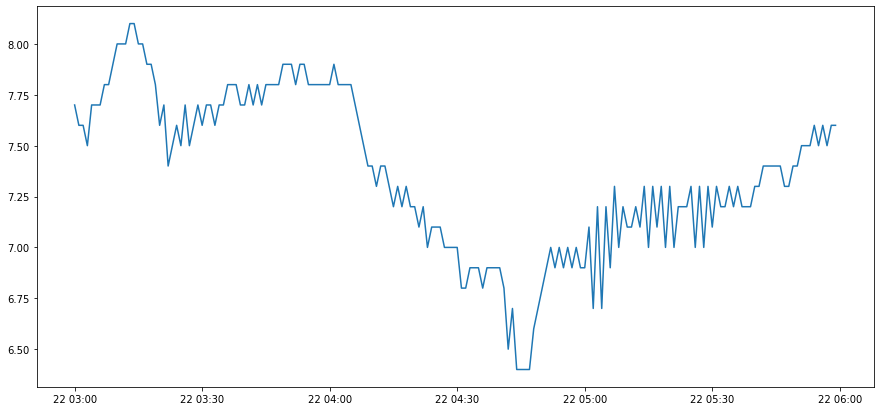

In [20]:
grapeNEva(model, X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)

In [34]:
X_test = japonica_validation_test.loc['2021-07-21 04:30':'2021-07-31 19:29']

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 2))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 79 nVar: 2


In [35]:
y_date = japonica_validation_test.loc['2021-07-21 07:30':'2021-07-31 22:29']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 14220 nVar: 1
nCar: 79 nVar: 180


14220


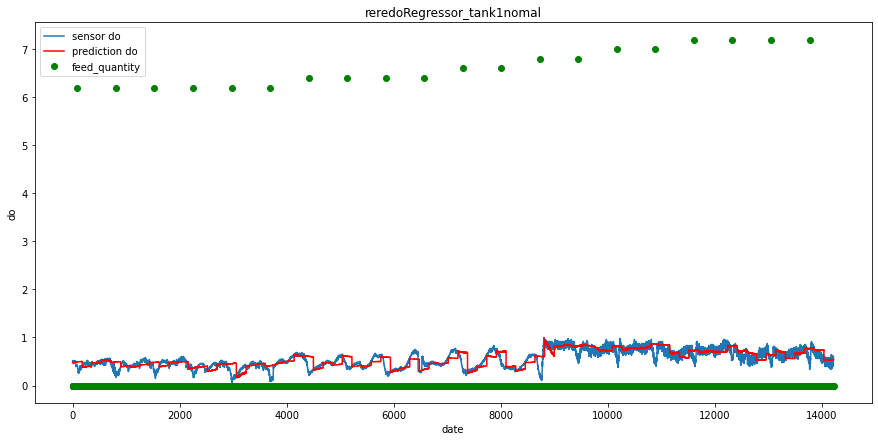

3/3 [==============================] - 0s 20ms/step - loss: 0.0157 - mae: 0.0914 - r_squared: 0.0926
MSE // MAE // R-squared  [0.015684232115745544, 0.09138339012861252, 0.09256017208099365]
14220


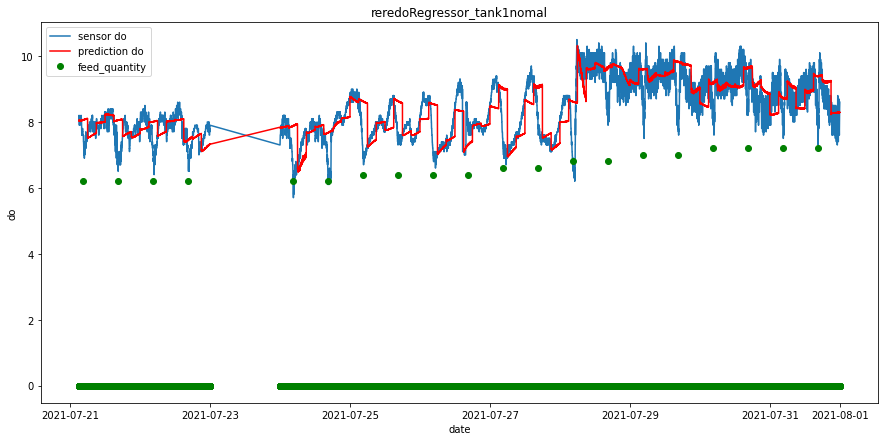

3/3 [==============================] - 0s 17ms/step - loss: 0.0157 - mae: 0.0914 - r_squared: 0.0926
MSE // MAE // R-squared  [0.015684232115745544, 0.09138339012861252, 0.09256017208099365]


In [37]:
grapeNEva(model, X_test_reshape, y_test_nomal, y_date[['feed_quantity']], y_test_reshape)

In [38]:
X_test = japonica_validation_test.loc['2021-07-21 04:30':'2021-07-21 19:29']

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 2))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 7 nVar: 2


In [39]:
y_date = japonica_validation_test.loc['2021-07-21 07:30':'2021-07-21 22:29']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1260 nVar: 1
nCar: 7 nVar: 180


1260


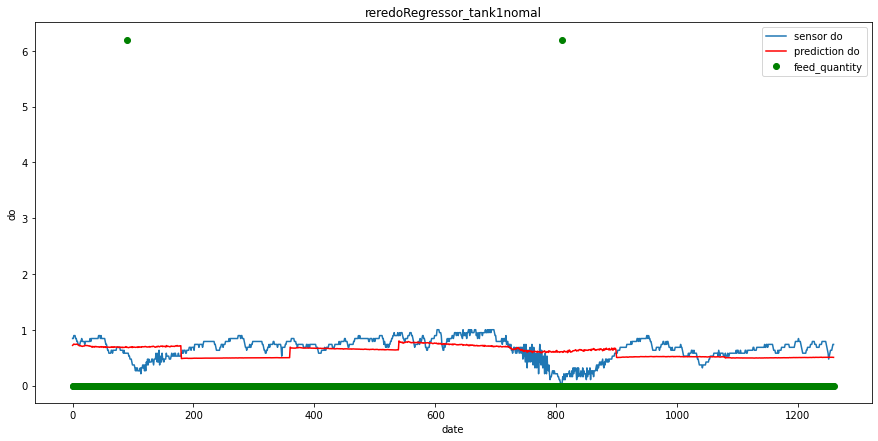

1/1 [==============================] - 0s 74ms/step - loss: 0.0457 - mae: 0.1818 - r_squared: -0.2342
MSE // MAE // R-squared  [0.045654308050870895, 0.18184199929237366, -0.23420631885528564]
1260


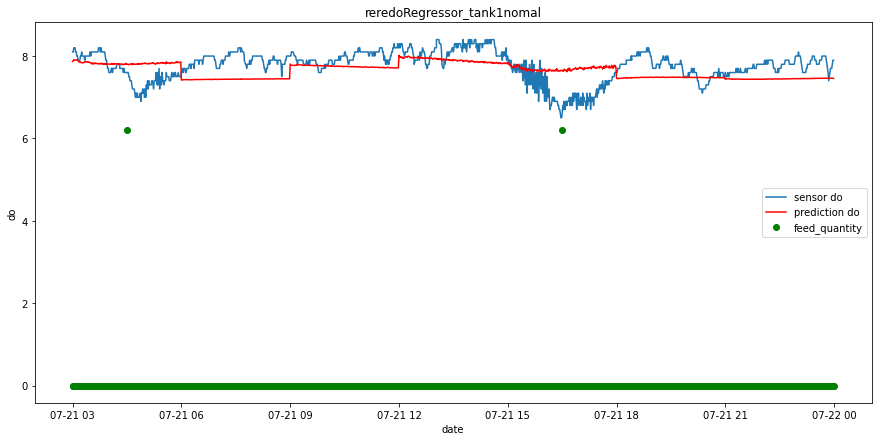

1/1 [==============================] - 0s 65ms/step - loss: 0.0457 - mae: 0.1818 - r_squared: -0.2342
MSE // MAE // R-squared  [0.045654308050870895, 0.18184199929237366, -0.23420631885528564]


In [40]:
grapeNEva(model, X_test_reshape, y_test_nomal, y_date[['feed_quantity']], y_test_reshape)

In [41]:
X_test = japonica_validation_test.loc['2021-07-21 04:30':'2021-07-21 16:30']

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 2))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 4 nVar: 2


In [42]:
y_date = japonica_validation_test.loc['2021-07-21 07:30':'2021-07-21 19:30']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 1
nCar: 4 nVar: 180


720


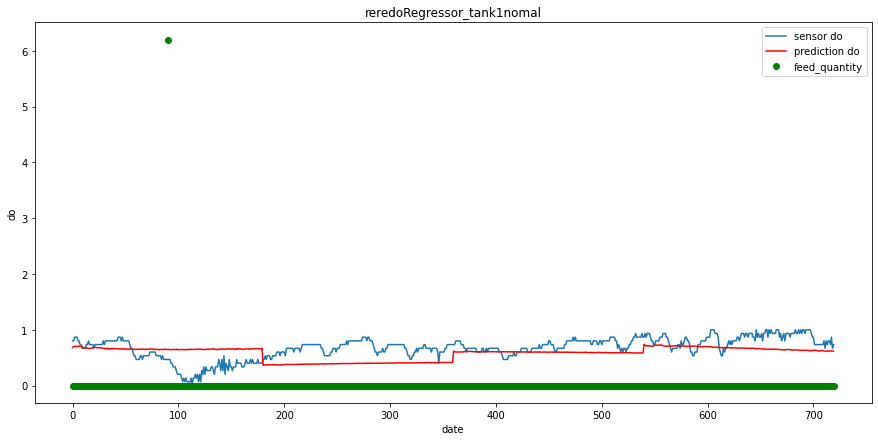

1/1 [==============================] - 0s 63ms/step - loss: 0.0571 - mae: 0.2036 - r_squared: -0.5591
MSE // MAE // R-squared  [0.05713215470314026, 0.20356234908103943, -0.5590775012969971]
720


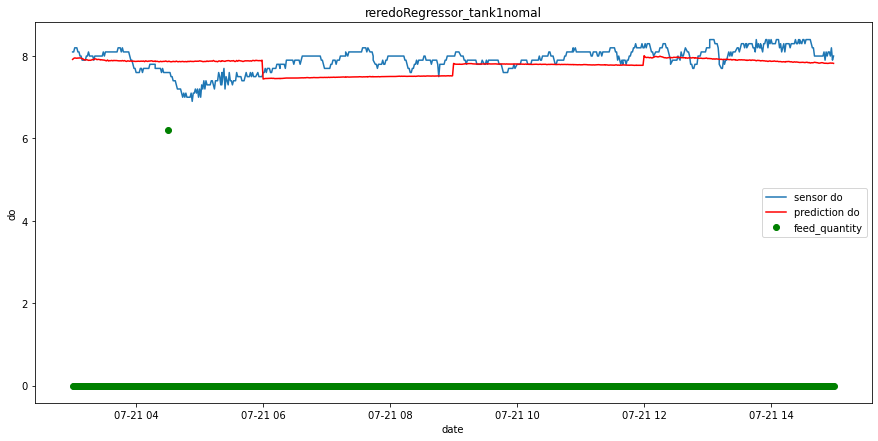

1/1 [==============================] - 0s 53ms/step - loss: 0.0571 - mae: 0.2036 - r_squared: -0.5591
MSE // MAE // R-squared  [0.05713215470314026, 0.20356234908103943, -0.5590775012969971]


In [43]:
grapeNEva(model, X_test_reshape, y_test_nomal, y_date[['feed_quantity']], y_test_reshape)